### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import time
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, AveragePooling2D, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models, layers, optimizers, callbacks


All modules imported successfully!


### Data Preparation 

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling

# Define the dataset directory
dataset_directory = r"C:\Users\HP\Desktop\unipd\HDA\My_Project\covid19-pneumonia-normal-chest-xraypa-dataset\COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset"

# Data processing
BATCH_SIZE = 16  # Number of images to process in each batch
IMG_SIZE = (224, 224)  # Size to which each image will be resized
AUTOTUNE = tf.data.AUTOTUNE  # Setting for automatic tuning of data loading

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    #This function automatically loads images from the folder, assuming that each subdirectory corresponds to a class label
    dataset_directory,  # Path to the dataset directory
    labels='inferred',  # Automatically infer labels from directory structure
    label_mode='categorical',  #one-hot encoded labels, each label will be represented as a vector (e.g., [1, 0, 0] for COVID)
    batch_size=BATCH_SIZE,  # Batch size for data loading
    image_size=IMG_SIZE,  # Resize images to this size
    shuffle=True,  # Shuffle the dataset for randomness
    seed=123  # Seed for reproducibility
)


class_names = dataset.class_names
print(class_names)  # Print the class names (subdirectories) in the dataset

# Function to split the dataset into training, validation, and test sets
def split_dataset(ds, train_split=0.8, val_split=0.1):
    train_size = int(train_split * len(ds))  # Calculate the number of training samples
    val_size = int(val_split * len(ds))  # Calculate the number of validation samples
    
    train_ds = ds.take(train_size)  # Take the first part of the dataset for training
    val_ds = ds.skip(train_size).take(val_size)  # Take the next part for validation
    test_ds = ds.skip(train_size + val_size)  # The rest is for testing
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)  # Split the dataset

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),  # Apply random rotation
    tf.keras.layers.RandomZoom(0.1),  # Apply random zoom
    tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05),  # Apply random translation
    tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Define preprocessing for validation and test datasets (without data augmentation)
preprocess_only_rescaling = tf.keras.Sequential([
    Rescaling(1./255)  # Normalize pixel values to [0, 1]
])

# Apply preprocessing to validation and test datasets
val_ds = val_ds.map(lambda x, y: (preprocess_only_rescaling(x, training=False), y))
test_ds = test_ds.map(lambda x, y: (preprocess_only_rescaling(x, training=False), y))

# Prepare the dataset for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)  # Cache, shuffle, and prefetch training data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)  # Cache and prefetch validation data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)  # Cache and prefetch test data


Found 4575 files belonging to 3 classes.
['covid', 'normal', 'pneumonia']


### Model Development 

In [3]:
# Define a function to build a basic CNN model for image classification
def build_basic_cnn(input_shape, num_classes):
    
    # Initialize a Sequential model (a linear stack of layers)
    model = tf.keras.Sequential([
        
        # Input layer defining the input shape (e.g., image dimensions)
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block: Convolution layer with 16 filters, 3x3 kernel size, ReLU activation, and L2 regularization
        # L2 regularization helps prevent overfitting by penalizing large weights
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  
        
        # Max pooling layer to downsample the feature maps by taking the max value in each 2x2 window
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block: Convolution layer with 32 filters, same kernel size and activation, with L2 regularization
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  
        
        # Another max pooling layer to downsample further
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block: Convolution layer with 64 filters, increasing the depth of the feature maps
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  
        
        # Max pooling to reduce the spatial dimensions again
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten the 3D output from the convolutional layers into a 1D vector
        # This prepares the data for the fully connected (dense) layers
        tf.keras.layers.Flatten(),
        
        # Fully connected (dense) layer with 64 units and ReLU activation
        # L2 regularization is applied to prevent overfitting by controlling the weight values
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  
        
        # Dropout layer to randomly set a fraction of the input units to 0, preventing overfitting
        # Dropout rate is set to 0.4, meaning 40% of the units are dropped
        tf.keras.layers.Dropout(0.4), 
        
        # Output layer with 'num_classes' units (corresponding to the number of classes)
        # Softmax activation to convert the output to probability distribution over the classes
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Return the constructed model
    return model



"""
Initialization: The model is created as a Sequential model, which allows for stacking layers one by one.

Convolutional Layers: Each block has a convolutional layer followed by a max pooling layer. L2 regularization is applied to 
the convolutional layers to prevent overfitting by discouraging large weight values.

Flattening: After extracting the features using convolutional layers, the 3D feature maps are flattened into a 1D vector.

Fully Connected Layers: Dense layers are used for classification, where the output size is reduced to match the number of 
classes.

Dropout: Applied before the output layer to prevent overfitting by randomly turning off some neurons during training.

Final Layer: Uses a softmax activation function to output probabilities for multi-class classification.
"""

In [11]:
# Define a function to build a CNN model with Depth-Wise Separable Convolutions for image classification
def build_depthwise_cnn(input_shape, num_classes):
    
    # Initialize a Sequential model (a linear stack of layers)
    model = tf.keras.Sequential([
        
        # Input layer defining the input shape (e.g., image dimensions)
        tf.keras.layers.Input(shape=input_shape),
        
        # First Depth-Wise Separable Convolutional Block
        # SeparableConv2D splits the convolution into depth-wise and point-wise convolutions, reducing parameters and computation
        # use_bias=False: No bias is added because BatchNormalization is applied afterward
        tf.keras.layers.SeparableConv2D(16, (3, 3), activation='relu', use_bias=False),
        
        # Batch Normalization to normalize the activations, helping the network converge faster
        tf.keras.layers.BatchNormalization(),  
        
        # Max pooling layer to downsample the feature maps by taking the max value in each 2x2 window
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second Depth-Wise Separable Convolutional Block
        tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', use_bias=False),
        tf.keras.layers.BatchNormalization(),  # Normalize after the convolution
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third Depth-Wise Separable Convolutional Block
        tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu', use_bias=False),
        tf.keras.layers.BatchNormalization(),  # Normalize to stabilize the learning process
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten the 3D output from the convolutional layers into a 1D vector
        # This prepares the data for the fully connected (dense) layers
        tf.keras.layers.Flatten(),
        
        # Fully connected (dense) layer with 64 units and ReLU activation
        # L2 regularization is applied to prevent overfitting by penalizing large weights
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        
        # Dropout layer to randomly set 40% of the input units to 0, preventing overfitting
        tf.keras.layers.Dropout(0.4),  
        
        # Output layer with 'num_classes' units (corresponding to the number of classes)
        # Softmax activation to convert the output to a probability distribution over the classes
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Return the constructed model
    return model


"""
Depth-Wise Separable Convolutions: Separable convolutions are used instead of regular convolutions to split 
the operation into two parts: depth-wise (independent per input channel) and point-wise (1x1 convolutions across channels). 
This significantly reduces computational complexity while maintaining performance.

Batch Normalization: After each separable convolution, Batch Normalization is applied to normalize the activations. 
This helps stabilize and speed up the training process by reducing internal covariate shift.

Pooling: MaxPooling is used after each convolutional block to reduce the spatial dimensions of the feature maps, 
extracting the most important features.

Dense Layer and Regularization: A dense layer is used for classification after the convolutional layers, 
and L2 regularization is applied to the weights to reduce overfitting.

Dropout: Dropout is applied before the final output layer to randomly drop units and improve generalization by 
preventing overfitting.

Final Layer: The softmax layer converts the outputs into a probability distribution for classification into num_classes.
"""

In [12]:
# Define a function to build a CNN model with an Attention Mechanism for image classification
def build_cnn_with_attention(input_shape, num_classes):
    
    # Input layer defining the input shape (e.g., image dimensions)
    inputs = tf.keras.Input(shape=input_shape)

    # First convolutional block with L2 regularization
    # Conv2D layer with 16 filters, 3x3 kernel size, ReLU activation, and L2 regularization to prevent overfitting
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    
    # Max pooling to downsample the feature maps, reducing the spatial dimensions
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Second convolutional block with L2 regularization
    # Conv2D layer with 32 filters, increasing feature depth
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    # Max pooling to reduce spatial dimensions further
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Third convolutional block with L2 regularization
    # Conv2D layer with 64 filters to extract more complex features
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    # Max pooling to continue reducing spatial dimensions
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Attention Mechanism (Spatial Attention)
    # Conv2D layer with 1 filter and sigmoid activation to generate an attention map
    # The attention map highlights the important spatial regions in the feature maps
    attention = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    # Multiply the feature maps by the attention map, allowing the network to focus on important areas
    x = tf.keras.layers.Multiply()([x, attention])

    # Flatten the 3D output into a 1D vector for the fully connected (dense) layers
    x = tf.keras.layers.Flatten()(x)

    # Fully connected (dense) layer with 64 units, ReLU activation, and L2 regularization to prevent overfitting
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    # Dropout to randomly set 40% of the input units to 0, preventing overfitting
    x = tf.keras.layers.Dropout(0.4)(x)

    # Output layer with 'num_classes' units (corresponding to the number of classes)
    # Softmax activation to convert the output to a probability distribution over the classes
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model by specifying the inputs and outputs
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    # Return the constructed model
    return model


"""
Convolutional Layers: There are three convolutional blocks, each followed by a max pooling layer to reduce 
the spatial dimensions. L2 regularization is used in each convolutional layer to prevent overfitting by 
penalizing large weights.

Attention Mechanism: A spatial attention mechanism is introduced after the third convolutional block:
    *The attention map is generated using a Conv2D layer with a single filter and a sigmoid activation function. 
    This map highlights important regions in the feature map.
    
    *The Multiply layer multiplies the attention map with the original feature map, enabling the network to focus on 
    the most important spatial features.

Flattening: The feature maps are flattened into a 1D vector for the fully connected (dense) layers.

Dense Layer and Regularization: The dense layer has 64 units with L2 regularization and a ReLU activation. 
The regularization helps reduce overfitting.

Dropout: Dropout is applied before the final output layer to improve generalization by randomly dropping units 
during training.

Output Layer: The final layer uses a softmax activation to classify the output into num_classes, 
converting the output into a probability distribution.

This model is designed to use spatial attention to focus on the most important areas in the image,
improving the model's ability to identify relevant features for classification.
"""

In [48]:
# Define DenseNet Block
def dense_block(x, num_layers, growth_rate, name, dropout_rate=0.4):
    """Construct a Dense Block with num_layers layers."""
    # Loop through each layer in the dense block
    for i in range(num_layers):
        # Add a convolutional block for each layer in the dense block
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1), dropout_rate=dropout_rate)
    # Return the resulting feature maps from the dense block
    return x

# Define a Convolutional Block used in DenseNet
def conv_block(x, growth_rate, name, dropout_rate=0.4):
    """A basic DenseNet Convolutional Block."""
    # Batch normalization to stabilize and speed up training
    x1 = tf.keras.layers.BatchNormalization(name=name + '_bn')(x)
    
    # ReLU activation for non-linearity
    x1 = tf.keras.layers.Activation('relu', name=name + '_relu')(x1)
    
    # First 1x1 convolution to reduce the number of features (bottleneck layer)
    x1 = tf.keras.layers.Conv2D(4 * growth_rate, (1, 1), use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.001), name=name + '_conv1')(x1)
    
    # Batch normalization after the first convolution
    x1 = tf.keras.layers.BatchNormalization(name=name + '_bn2')(x1)
    
    # ReLU activation again
    x1 = tf.keras.layers.Activation('relu', name=name + '_relu2')(x1)
    
    # Second 3x3 convolution to process the spatial features, output channels are equal to the growth rate
    x1 = tf.keras.layers.Conv2D(growth_rate, (3, 3), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.001), name=name + '_conv2')(x1)
    
    # Apply dropout if specified to prevent overfitting
    if dropout_rate:
        x1 = tf.keras.layers.Dropout(dropout_rate)(x1)
    
    # Concatenate the input (x) with the output of this block (x1), following DenseNet's key idea
    x = tf.keras.layers.Concatenate(name=name + '_concat')([x, x1])
    
    return x

# Define a Transition Layer to reduce dimensionality
def transition_layer(x, reduction, name, dropout_rate=0.4):
    """A transition layer for DenseNet."""
    # Batch normalization before applying the transition
    x = tf.keras.layers.BatchNormalization(name=name + '_bn')(x)
    
    # ReLU activation
    x = tf.keras.layers.Activation('relu', name=name + '_relu')(x)
    
    # 1x1 convolution to reduce the number of feature maps, controlled by the 'reduction' factor
    x = tf.keras.layers.Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), (1, 1), use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.001), name=name + '_conv')(x)
    
    # Apply dropout if specified
    if dropout_rate:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # MaxPooling to reduce the spatial dimensions (height and width)
    x = tf.keras.layers.MaxPooling2D((2, 2), name=name + '_pool')(x)
    
    return x

# Build the CNN with DenseNet Architecture
def build_cnn_with_densenet(input_shape, num_classes):
    
    # Input layer defining the input shape (e.g., image dimensions)
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolutional layer with 16 filters and 3x3 kernel size
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    
    # MaxPooling to reduce spatial dimensions
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # First Dense Block (2 layers with growth rate of 8)
    # The number of filters grows by 8 with each new layer
    x = dense_block(x, num_layers=2, growth_rate=8, name='dense1', dropout_rate=0.4)
    
    # Transition Layer 1: Reducing the number of filters by 50% (reduction factor = 0.5)
    x = transition_layer(x, reduction=0.5, name='trans1')

    # Second Dense Block (2 layers with growth rate of 16)
    # The number of filters grows by 16 with each new layer
    x = dense_block(x, num_layers=2, growth_rate=16, name='dense2', dropout_rate=0.4)
    
    # Transition Layer 2: Reducing the number of filters by 50% (reduction factor = 0.5)
    x = transition_layer(x, reduction=0.5, name='trans2')

    # Third Dense Block (2 layers with growth rate of 32)
    # The number of filters grows by 32 with each new layer
    x = dense_block(x, num_layers=2, growth_rate=32, name='dense3', dropout_rate=0.4)

    # Batch normalization to normalize the output before final pooling
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Global Average Pooling to reduce the feature maps to a single value per feature (global pooling)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Fully connected (dense) layer with 64 units and ReLU activation, using L2 regularization to prevent overfitting
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    # Dropout layer to randomly drop 40% of units, preventing overfitting
    x = tf.keras.layers.Dropout(0.4)(x)

    # Output layer with 'num_classes' units, using softmax activation for multi-class classification
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the model by specifying inputs and outputs
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    # Return the constructed model
    return model


"""
Dense Block: Each dense block is composed of several conv_blocks. 
A dense block connects each layer to every other layer in a feed-forward manner, 
meaning each layer's output is concatenated with the outputs of all previous layers, 
allowing the network to use all features from earlier layers.

Convolutional Block: Each conv_block contains:
    *A 1x1 convolution (bottleneck) to reduce the dimensionality before applying a 
    more computationally expensive 3x3 convolution.
    *Batch normalization and ReLU activation are applied before each convolution.
    *Dropout is applied optionally to prevent overfitting.
    
Transition Layer: This layer reduces the dimensionality between dense blocks using:
    *1x1 convolution to reduce the number of filters (using a reduction factor).
    *MaxPooling is used to reduce the spatial dimensions, similar to a basic CNN.
    
Global Average Pooling: A GlobalAveragePooling2D layer reduces each feature map into a single value by averaging 
all its values, making the network less prone to overfitting and reducing the number of parameters.

Fully Connected and Output Layers: The model ends with a dense layer followed by a softmax output for classification.

This architecture uses the core ideas of DenseNet—efficient use of feature maps through concatenation, with transition 
layers that reduce complexity. The model is designed to capture complex patterns while keeping computational 
costs relatively low compared to traditional deep networks.
"""

In [49]:
# Define the callbacks: ModelCheckpoint and EarlyStopping
checkpoint_basic_cnn = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoints/basic_cnn.keras',  # File path to save the model
    monitor='val_accuracy',  # Monitor the validation accuracy
    save_best_only=True,  # Save only the model with the best validation accuracy
    mode='max',  # Maximize the monitored metric (accuracy)
    verbose=1  # Print logs when the model improves
)

checkpoint_depthwise_cnn = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoints/depthwise_cnn.keras',  # File path to save the model
    monitor='val_accuracy',  # Monitor the validation accuracy
    save_best_only=True,  # Save only the model with the best validation accuracy
    mode='max',  # Maximize the monitored metric (accuracy)
    verbose=1  # Print logs when the model improves
)

checkpoint_attention_cnn = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoints/attention_cnn.keras',  # File path to save the model
    monitor='val_accuracy',  # Monitor the validation accuracy
    save_best_only=True,  # Save only the model with the best validation accuracy
    mode='max',  # Maximize the monitored metric (accuracy)
    verbose=1  # Print logs when the model improves
)

checkpoint_densenet = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoints/densenet.keras',  # File path to save the model
    monitor='val_accuracy',  # Monitor the validation accuracy
    save_best_only=True,  # Save only the model with the best validation accuracy
    mode='max',  # Maximize the monitored metric (accuracy)
    verbose=1  # Print logs when the model improves
)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,  # Stop training if the validation loss does not improve for 5 epochs
    mode='min',  # Minimize the monitored metric (loss)
    verbose=1,  # Print logs when early stopping is triggered
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 5:  # For the first 5 epochs, keep the learning rate constant
        return float(lr)
    else:  # After epoch 5, decay the learning rate exponentially
        return float(lr * tf.math.exp(-0.1).numpy())  # Ensure it's cast to a float

# Create a learning rate scheduler callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Callback lists for each model
callbacks_basic_cnn = [checkpoint_basic_cnn, early_stopping_callback, lr_schedule]
callbacks_depthwise_cnn = [checkpoint_depthwise_cnn, early_stopping_callback, lr_schedule]
callbacks_attention_cnn = [checkpoint_attention_cnn, early_stopping_callback, lr_schedule]
callbacks_densenet = [checkpoint_densenet, early_stopping_callback, lr_schedule]

# Function to train the model
def train_model(model, train_ds, val_ds, callbacks, epochs=20):
    start_time = time.time()  # Start timer
    history = model.fit(
        train_ds,
        epochs=epochs,  # Number of epochs to train
        validation_data=val_ds,  # Validation dataset
        callbacks=callbacks,  # List of callbacks
        verbose=1  # Verbosity mode
    )
    end_time = time.time()  # End timer
    training_time = end_time - start_time  # Calculate training time
    
    print("\nTraining completed. Final epoch metrics:")
    print("Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(
        history.history['loss'][-1], history.history['accuracy'][-1]))
    print("Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(
        history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
    print(f"Total training time for {epochs} epochs: {training_time:.2f} seconds")
    return history, training_time

# Compile the model with additional metrics and initial learning rate
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Adam optimizer with learning rate
        loss='categorical_crossentropy',  # Loss function
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(name='auc')]  # List of metrics
    )
    return model


### Training

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Dictionary to store the training and testing metrics for each model
model_metrics = {
    'Model': [],
    'Epoch': [],
    'Train Accuracy': [],
    'Train Precision': [],
    'Train Recall': [],
    'Train F1-Score': [],
    'Train Loss': [],
    'Val Accuracy': [],
    'Val Precision': [],
    'Val Recall': [],
    'Val F1-Score': [],
    'Val Loss': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'Test F1-Score': [],
    'Test Loss': []
}

# Function to train and evaluate a model and save the metrics
def train_and_evaluate_model(model, model_name, train_ds, val_ds, test_ds, callbacks, epochs=20):
    # Train the model
    print(f"********************************* Start training {model_name} model ********************************")
    history, training_time = train_model(
        model, 
        train_ds, 
        val_ds, 
        callbacks=callbacks, 
        epochs=epochs
    )

    # Get the actual number of epochs run
    actual_epochs = len(history.history['accuracy'])  # This ensures we only iterate over completed epochs

    # Get the exact names of precision and recall from history.history
    precision_key = None
    recall_key = None
    val_precision_key = None
    val_recall_key = None
    
    # Dynamically identify the precision and recall keys (to avoid KeyError)
    for key in history.history.keys():
        if 'precision' in key:
            if 'val_' in key:
                val_precision_key = key
            else:
                precision_key = key
        if 'recall' in key:
            if 'val_' in key:
                val_recall_key = key
            else:
                recall_key = key

    # Store training and validation metrics
    for epoch in range(actual_epochs):  # Use the actual number of epochs
        model_metrics['Model'].append(model_name)
        model_metrics['Epoch'].append(epoch+1)
        model_metrics['Train Accuracy'].append(history.history['accuracy'][epoch])
        model_metrics['Train Precision'].append(history.history[precision_key][epoch])
        model_metrics['Train Recall'].append(history.history[recall_key][epoch])
        model_metrics['Train Loss'].append(history.history['loss'][epoch])

        # Validation metrics
        model_metrics['Val Accuracy'].append(history.history['val_accuracy'][epoch])
        model_metrics['Val Precision'].append(history.history[val_precision_key][epoch])
        model_metrics['Val Recall'].append(history.history[val_recall_key][epoch])
        model_metrics['Val Loss'].append(history.history['val_loss'][epoch])

        # Compute F1-Score from Precision and Recall
        train_f1 = 2 * (history.history[precision_key][epoch] * history.history[recall_key][epoch]) / (history.history[precision_key][epoch] + history.history[recall_key][epoch])
        val_f1 = 2 * (history.history[val_precision_key][epoch] * history.history[val_recall_key][epoch]) / (history.history[val_precision_key][epoch] + history.history[val_recall_key][epoch])
        model_metrics['Train F1-Score'].append(train_f1)
        model_metrics['Val F1-Score'].append(val_f1)

    # Evaluate model on the test set
    print(f"Evaluating {model_name} model on test set...")
    test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_ds)
    
    # Compute F1-Score for the test set
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

    # Store test metrics
    model_metrics['Test Accuracy'].append(test_accuracy)
    model_metrics['Test Precision'].append(test_precision)
    model_metrics['Test Recall'].append(test_recall)
    model_metrics['Test F1-Score'].append(test_f1)
    model_metrics['Test Loss'].append(test_loss)

    # Print final test metrics
    print(f"Test metrics for {model_name}: Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1-Score: {test_f1}, AUC: {test_auc}")

# Convert model_metrics to a DataFrame for analysis
metrics_df = pd.DataFrame(model_metrics)
metrics_df.to_csv('model_metrics.csv', index=False)  # Save metrics to a CSV file for later use


In [51]:
# Define the number of classes and input shape
num_classes = 3  # Assuming 3 classes: COVID-19, pneumonia, normal
input_shape = (224, 224, 3)  # Input shape for the images

In [36]:
# Build and compile the Basic CNN model
basic_cnn = build_basic_cnn(input_shape, num_classes)  # Build the model
basic_cnn = compile_model(basic_cnn)  # Compile the model

# Train and evaluate Basic CNN model
train_and_evaluate_model(basic_cnn, "Basic CNN", train_ds, val_ds, test_ds, callbacks_basic_cnn)


********************************* Start training Basic CNN model ********************************
Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.5413 - auc: 0.7307 - loss: 1.0608 - precision_3: 0.6472 - recall_3: 0.3007
Epoch 1: val_accuracy improved from -inf to 0.78125, saving model to model_checkpoints/basic_cnn.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.5418 - auc: 0.7311 - loss: 1.0602 - precision_3: 0.6476 - recall_3: 0.3015 - val_accuracy: 0.7812 - val_auc: 0.9234 - val_loss: 0.6404 - val_precision_3: 0.8450 - val_recall_3: 0.7299 - learning_rate: 5.0000e-04
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7192 - auc: 0.8813 - loss: 0.7689 - precision_3: 0.7909 - recall_3: 0.6016
Epoch 2: val_accuracy improved from 0.78125 to 0.82143, saving model to model_checkpoints/basic_cnn.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.7192 - auc: 0.8813 - loss: 0.7688 - precision_3: 0.7909 - recall_3: 0.6017 - va

In [17]:
# Build and compile the Depthwise CNN model
advanced_depthwise_cnn = build_depthwise_cnn(input_shape, num_classes)  # Build the model
advanced_depthwise_cnn = compile_model(advanced_depthwise_cnn)  # Compile the model

# Train and evaluate Depthwise CNN model
train_and_evaluate_model(advanced_depthwise_cnn, "Depthwise CNN", train_ds, val_ds, test_ds, callbacks_depthwise_cnn)


********************************* Start training Depthwise CNN model ********************************
Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6521 - auc: 0.8243 - loss: 1.5551 - precision: 0.7112 - recall: 0.5765
Epoch 1: val_accuracy improved from -inf to 0.33036, saving model to model_checkpoints/depthwise_cnn.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 104s 320ms/step - accuracy: 0.6523 - auc: 0.8245 - loss: 1.5530 - precision: 0.7115 - recall: 0.5765 - val_accuracy: 0.3304 - val_auc: 0.6708 - val_loss: 2.0623 - val_precision: 0.3304 - val_recall: 0.3304 - learning_rate: 5.0000e-04
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7663 - auc: 0.9153 - loss: 0.7563 - precision: 0.8409 - recall: 0.6412
Epoch 2: val_accuracy improved from 0.33036 to 0.74554, saving model to model_checkpoints/depthwise_cnn.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - accuracy: 0.7663 - auc: 0.9153 - loss: 0.7563 - precision: 0.8410 - recall: 0.6412 - val_accur

In [18]:
# Build and compile the CNN with Attention model
advanced_cnn_with_attention = build_cnn_with_attention(input_shape, num_classes)  # Build the model
advanced_cnn_with_attention = compile_model(advanced_cnn_with_attention)  # Compile the model

# Train and evaluate CNN with Attention model
train_and_evaluate_model(advanced_cnn_with_attention, "CNN with Attention", train_ds, val_ds, test_ds, callbacks_attention_cnn)


********************************* Start training CNN with Attention model ********************************
Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5419 - auc: 0.7182 - loss: 1.0472 - precision_1: 0.6593 - recall_1: 0.2788
Epoch 1: val_accuracy improved from -inf to 0.81027, saving model to model_checkpoints/attention_cnn.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.5423 - auc: 0.7187 - loss: 1.0465 - precision_1: 0.6597 - recall_1: 0.2796 - val_accuracy: 0.8103 - val_auc: 0.9316 - val_loss: 0.5841 - val_precision_1: 0.8278 - val_recall_1: 0.7835 - learning_rate: 5.0000e-04
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7219 - auc: 0.8896 - loss: 0.7247 - precision_1: 0.7962 - recall_1: 0.6259
Epoch 2: val_accuracy did not improve from 0.81027
228/228 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.7220 - auc: 0.8896 - loss: 0.7246 - precision_1: 0.7962 - recall_1: 0.6260 - val_accuracy: 0.7969 - val_auc: 0.9232 - val

228/228 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.8645 - auc: 0.9688 - loss: 0.4305 - precision_1: 0.9003 - recall_1: 0.8345 - val_accuracy: 0.8951 - val_auc: 0.9652 - val_loss: 0.4625 - val_precision_1: 0.8998 - val_recall_1: 0.8817 - learning_rate: 1.8394e-04
Epoch 16/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8610 - auc: 0.9706 - loss: 0.4168 - precision_1: 0.9032 - recall_1: 0.8311
Epoch 16: val_accuracy did not improve from 0.89509
228/228 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.8611 - auc: 0.9706 - loss: 0.4168 - precision_1: 0.9032 - recall_1: 0.8311 - val_accuracy: 0.8839 - val_auc: 0.9646 - val_loss: 0.4601 - val_precision_1: 0.8950 - val_recall_1: 0.8750 - learning_rate: 1.6644e-04
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 11.

Training completed. Final epoch metrics:
Train Loss: 0.4146, Train Accuracy: 0.8679
Validation Loss: 0.4601, Validation Accuracy: 0.8839
Total training time for 20 epochs: 444.47

In [52]:
# Build and compile the DenseNet model
densenet = build_cnn_with_densenet(input_shape, num_classes)  # Build the model
densenet = compile_model(densenet)  # Compile the model

# Train and evaluate DenseNet model
train_and_evaluate_model(densenet, "DenseNet", train_ds, val_ds, test_ds, callbacks_densenet)


********************************* Start training DenseNet model ********************************
Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.5473 - auc: 0.7278 - loss: 1.4614 - precision_5: 0.6443 - recall_5: 0.2748
Epoch 1: val_accuracy improved from -inf to 0.35714, saving model to model_checkpoints/densenet.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 135s 556ms/step - accuracy: 0.5475 - auc: 0.7281 - loss: 1.4610 - precision_5: 0.6446 - recall_5: 0.2754 - val_accuracy: 0.3571 - val_auc: 0.5291 - val_loss: 3.0154 - val_precision_5: 0.3571 - val_recall_5: 0.3571 - learning_rate: 5.0000e-04
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7147 - auc: 0.8650 - loss: 1.1421 - precision_5: 0.7575 - recall_5: 0.6288
Epoch 2: val_accuracy did not improve from 0.35714
228/228 ━━━━━━━━━━━━━━━━━━━━ 126s 553ms/step - accuracy: 0.7148 - auc: 0.8651 - loss: 1.1418 - precision_5: 0.7576 - recall_5: 0.6290 - val_accuracy: 0.3080 - val_auc: 0.4973 - val_loss: 1.8038

### Numerical Values in Lists and Dictionaries to use for Plotting 

In [27]:
# basic_cnn
# Initialize dictionaries to store metrics
basic_cnn_train_metrics = {
    'accuracy': [],
    'loss': [],
    'precision': [],
    'recall': [],
    'auc': [],
    'f1_score': []
}

basic_cnn_val_metrics = {
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_auc': [],
    'val_f1_score': []
}


epochs = 20
# basic_cnn_train_metrics
basic_cnn_train_accuracy = [0.5922, 0.7623, 0.7953, 0.8008, 0.8151, 0.8341, 0.8540, 0.8630, 0.8704, 0.8809, 0.8962, 0.8950, 0.9037]
basic_cnn_train_loss = [0.9970, 0.6893, 0.6188, 0.5928, 0.5918, 0.5366, 0.4924, 0.4633, 0.4765, 0.4407, 0.4028, 0.3914, 0.3706]
basic_cnn_train_precision = [0.6466, 0.8006, 0.8249, 0.8360, 0.8492, 0.8711, 0.8771, 0.8863, 0.9003, 0.9015, 0.9138, 0.9150, 0.9208]
basic_cnn_train_recall = [0.3692, 0.6759, 0.7344, 0.7567, 0.7725, 0.7935, 0.8247, 0.8378, 0.8309, 0.8479, 0.8695, 0.8787, 0.8803]
basic_cnn_train_auc = [0.7711, 0.9077, 0.9292, 0.9356, 0.9386, 0.9517, 0.9612, 0.9670, 0.9658, 0.9722, 0.9781, 0.9797, 0.9826]
basic_cnn_train_f1_score = [0.3700, 0.6759, 0.7343, 0.7567, 0.7725, 0.7935, 0.8247, 0.8378, 0.8309, 0.8479, 0.8695, 0.8787, 0.8803]

# basic_cnn_val_metrics
basic_cnn_val_accuracy = [0.8393, 0.8661, 0.8527, 0.8594, 0.8817, 0.8862, 0.8862, 0.8839, 0.8638, 0.8661, 0.8862, 0.8795, 0.8862]
basic_cnn_val_loss = [0.5465, 0.5388, 0.5350, 0.4814, 0.4450, 0.4510, 0.4775, 0.4447, 0.5421, 0.5226, 0.4864, 0.4654, 0.4604]
basic_cnn_val_precision = [0.8535, 0.8854, 0.8668, 0.8794, 0.8881, 0.8914, 0.8951, 0.9026, 0.8707, 0.8716, 0.8914, 0.8864, 0.8937]
basic_cnn_val_recall = [0.8192, 0.8281, 0.8281, 0.8460, 0.8683, 0.8795, 0.8571, 0.8683, 0.8571, 0.8638, 0.8795, 0.8705, 0.8817]
basic_cnn_val_auc = [0.9469, 0.9532, 0.9525, 0.9604, 0.9689, 0.9692, 0.9660, 0.9719, 0.9567, 0.9610, 0.9672, 0.9699, 0.9724]
basic_cnn_val_f1_score = [0.8192, 0.8281, 0.8281, 0.8460, 0.8683, 0.8795, 0.8571, 0.8683, 0.8571, 0.8638, 0.8795, 0.8705, 0.8817]



# Store the metrics in dictionaries
for epoch in range(len(basic_cnn_train_accuracy)):
    basic_cnn_train_metrics['accuracy'].append(basic_cnn_train_accuracy[epoch])
    basic_cnn_train_metrics['loss'].append(basic_cnn_train_loss[epoch])
    basic_cnn_train_metrics['precision'].append(basic_cnn_train_precision[epoch])
    basic_cnn_train_metrics['recall'].append(basic_cnn_train_recall[epoch])
    basic_cnn_train_metrics['auc'].append(basic_cnn_train_auc[epoch])
    basic_cnn_train_metrics['f1_score'].append(basic_cnn_train_f1_score[epoch])
    
    basic_cnn_val_metrics['val_accuracy'].append(basic_cnn_val_accuracy[epoch])
    basic_cnn_val_metrics['val_loss'].append(basic_cnn_val_loss[epoch])
    basic_cnn_val_metrics['val_precision'].append(basic_cnn_val_precision[epoch])
    basic_cnn_val_metrics['val_recall'].append(basic_cnn_val_recall[epoch])
    basic_cnn_val_metrics['val_auc'].append(basic_cnn_val_auc[epoch])
    basic_cnn_val_metrics['val_f1_score'].append(basic_cnn_val_f1_score[epoch])

# Final evaluation metrics
basic_cnn_test_metrics = {
    'test_loss': 0.4639,  
    'test_accuracy': 0.8914,  
    'test_precision': 0.9658,  
    'test_recall': 0.9011,  
    'test_auc': 0.9596,  
    'test_f1_score': 0.9323  
}

basic_cnn_inference_metrics = {
    'average_inference_time_per_sample': 0.2002,
    'memory_usage_mb': 127.86  
}


# Print the metrics for verification
print("Basic CNN Training Metrics: ", basic_cnn_train_metrics)
print("Basic CNN Validation Metrics: ", basic_cnn_val_metrics)
print("Basic CNN Test Metrics: ", basic_cnn_test_metrics)
print("Basic CNN Inference Metrics: ", basic_cnn_inference_metrics)


Basic CNN Training Metrics:  {'accuracy': [0.5922, 0.7623, 0.7953, 0.8008, 0.8151, 0.8341, 0.854, 0.863, 0.8704, 0.8809, 0.8962, 0.895, 0.9037], 'loss': [0.997, 0.6893, 0.6188, 0.5928, 0.5918, 0.5366, 0.4924, 0.4633, 0.4765, 0.4407, 0.4028, 0.3914, 0.3706], 'precision': [0.6466, 0.8006, 0.8249, 0.836, 0.8492, 0.8711, 0.8771, 0.8863, 0.9003, 0.9015, 0.9138, 0.915, 0.9208], 'recall': [0.3692, 0.6759, 0.7344, 0.7567, 0.7725, 0.7935, 0.8247, 0.8378, 0.8309, 0.8479, 0.8695, 0.8787, 0.8803], 'auc': [0.7711, 0.9077, 0.9292, 0.9356, 0.9386, 0.9517, 0.9612, 0.967, 0.9658, 0.9722, 0.9781, 0.9797, 0.9826], 'f1_score': [0.37, 0.6759, 0.7343, 0.7567, 0.7725, 0.7935, 0.8247, 0.8378, 0.8309, 0.8479, 0.8695, 0.8787, 0.8803]}
Basic CNN Validation Metrics:  {'val_accuracy': [0.8393, 0.8661, 0.8527, 0.8594, 0.8817, 0.8862, 0.8862, 0.8839, 0.8638, 0.8661, 0.8862, 0.8795, 0.8862], 'val_loss': [0.5465, 0.5388, 0.535, 0.4814, 0.445, 0.451, 0.4775, 0.4447, 0.5421, 0.5226, 0.4864, 0.4654, 0.4604], 'val_precisi

In [29]:
# Initialize dictionaries to store metrics
depthwise_cnn_train_metrics = {
    'accuracy': [],
    'loss': [],
    'precision': [],
    'recall': [],
    'auc': [],
    'f1_score': []
}

depthwise_cnn_val_metrics = {
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_auc': [],
    'val_f1_score': []
}


# depthwise_cnn_train_metrics
depthwise_cnn_train_accuracy = [0.6521, 0.7663, 0.8117, 0.8157, 0.8602, 0.8740, 0.8975, 0.8919, 0.8993, 0.9168]
depthwise_cnn_train_loss = [1.5551, 0.7563, 0.6917, 0.6655, 0.5665, 0.5211, 0.4575, 0.4664, 0.4302, 0.3935]
depthwise_cnn_train_precision = [0.7112, 0.8409, 0.8659, 0.8775, 0.9020, 0.9143, 0.9297, 0.9313, 0.9392, 0.9437]
depthwise_cnn_train_recall = [0.5765, 0.6412, 0.6687, 0.7068, 0.7532, 0.7841, 0.8093, 0.8301, 0.8352, 0.8557]
depthwise_cnn_train_auc = [0.8243, 0.9153, 0.9342, 0.9441, 0.9625, 0.9696, 0.9787, 0.9774, 0.9814, 0.9854]
depthwise_cnn_train_f1_score = [0.5765, 0.6412, 0.6687, 0.7068, 0.7532, 0.7840, 0.8093, 0.8301, 0.8353, 0.8558]

# depthwise_cnn_val_metrics
depthwise_cnn_val_accuracy = [0.3304, 0.7455, 0.8772, 0.6763, 0.8951, 0.6094, 0.7545, 0.7902, 0.7411, 0.7210]
depthwise_cnn_val_loss = [2.0623, 1.2890, 0.6450, 1.0108, 0.6074, 2.6522, 1.0185, 1.0066, 1.0078, 1.4853]
depthwise_cnn_val_precision = [0.3304, 0.7557, 0.8973, 0.7098, 0.9021, 0.6085, 0.7592, 0.7937, 0.7444, 0.7230]
depthwise_cnn_val_recall = [0.3304, 0.7388, 0.8192, 0.6607, 0.8839, 0.6071, 0.7388, 0.7812, 0.7411, 0.7165]
depthwise_cnn_val_auc = [0.6708, 0.8825, 0.9511, 0.8897, 0.9641, 0.7755, 0.9108, 0.9205, 0.9171, 0.8775]
depthwise_cnn_val_f1_score = [0.3304, 0.7388, 0.8192, 0.6607, 0.8839, 0.6071, 0.7388, 0.7812, 0.7411, 0.7165]



# Store the metrics in dictionaries
for epoch in range(len(depthwise_cnn_train_accuracy)):
    depthwise_cnn_train_metrics['accuracy'].append(depthwise_cnn_train_accuracy[epoch])
    depthwise_cnn_train_metrics['loss'].append(depthwise_cnn_train_loss[epoch])
    depthwise_cnn_train_metrics['precision'].append(depthwise_cnn_train_precision[epoch])
    depthwise_cnn_train_metrics['recall'].append(depthwise_cnn_train_recall[epoch])
    depthwise_cnn_train_metrics['auc'].append(depthwise_cnn_train_auc[epoch])
    depthwise_cnn_train_metrics['f1_score'].append(depthwise_cnn_train_f1_score[epoch])
    
    depthwise_cnn_val_metrics['val_accuracy'].append(depthwise_cnn_val_accuracy[epoch])
    depthwise_cnn_val_metrics['val_loss'].append(depthwise_cnn_val_loss[epoch])
    depthwise_cnn_val_metrics['val_precision'].append(depthwise_cnn_val_precision[epoch])
    depthwise_cnn_val_metrics['val_recall'].append(depthwise_cnn_val_recall[epoch])
    depthwise_cnn_val_metrics['val_auc'].append(depthwise_cnn_val_auc[epoch])
    depthwise_cnn_val_metrics['val_f1_score'].append(depthwise_cnn_val_f1_score[epoch])

# Final evaluation metrics
depthwise_cnn_test_metrics = {
    'test_loss': 0.5865,  
    'test_accuracy': 0.8706,  
    'test_precision': 0.9619,  
    'test_recall': 0.8839,  
    'test_auc': 0.9572,  
    'test_f1_score': 0.9212  
}

# Inference time and memory usage
depthwise_cnn_inference_metrics = {
    'average_inference_time_per_sample': 0.5185,
    'memory_usage_mb': 2.63  
}


# Print the metrics for verification
print("Depthwise CNN Training Metrics: ", depthwise_cnn_train_metrics)
print("Depthwise CNN Validation Metrics: ", depthwise_cnn_val_metrics)
print("Depthwise CNN Test Metrics: ", depthwise_cnn_test_metrics)
print("Depthwise CNN Inference Metrics: ", depthwise_cnn_inference_metrics)


Depthwise CNN Training Metrics:  {'accuracy': [0.6521, 0.7663, 0.8117, 0.8157, 0.8602, 0.874, 0.8975, 0.8919, 0.8993, 0.9168], 'loss': [1.5551, 0.7563, 0.6917, 0.6655, 0.5665, 0.5211, 0.4575, 0.4664, 0.4302, 0.3935], 'precision': [0.7112, 0.8409, 0.8659, 0.8775, 0.902, 0.9143, 0.9297, 0.9313, 0.9392, 0.9437], 'recall': [0.5765, 0.6412, 0.6687, 0.7068, 0.7532, 0.7841, 0.8093, 0.8301, 0.8352, 0.8557], 'auc': [0.8243, 0.9153, 0.9342, 0.9441, 0.9625, 0.9696, 0.9787, 0.9774, 0.9814, 0.9854], 'f1_score': [0.5765, 0.6412, 0.6687, 0.7068, 0.7532, 0.784, 0.8093, 0.8301, 0.8353, 0.8558]}
Depthwise CNN Validation Metrics:  {'val_accuracy': [0.3304, 0.7455, 0.8772, 0.6763, 0.8951, 0.6094, 0.7545, 0.7902, 0.7411, 0.721], 'val_loss': [2.0623, 1.289, 0.645, 1.0108, 0.6074, 2.6522, 1.0185, 1.0066, 1.0078, 1.4853], 'val_precision': [0.3304, 0.7557, 0.8973, 0.7098, 0.9021, 0.6085, 0.7592, 0.7937, 0.7444, 0.723], 'val_recall': [0.3304, 0.7388, 0.8192, 0.6607, 0.8839, 0.6071, 0.7388, 0.7812, 0.7411, 0.716

In [30]:
# attention_cnn
# Initialize dictionaries to store metrics
attention_cnn_train_metrics = {
    'accuracy': [],
    'loss': [],
    'precision': [],
    'recall': [],
    'auc': [],
    'f1_score': []
}

attention_cnn_val_metrics = {
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_auc': [],
    'val_f1_score': []
}

# Updated attention_cnn_train_metrics
attention_cnn_train_accuracy = [0.5419, 0.7219, 0.7462, 0.7904, 0.7735, 0.7953, 0.8021, 0.8120, 0.8252, 0.8472]
attention_cnn_train_loss = [1.0472, 0.7247, 0.6819, 0.5974, 0.6058, 0.5988, 0.5725, 0.5516, 0.5163, 0.5072]
attention_cnn_train_precision = [0.6593, 0.7962, 0.8031, 0.8351, 0.8249, 0.8495, 0.8476, 0.8629, 0.8732, 0.8815]
attention_cnn_train_recall = [0.2788, 0.6259, 0.6590, 0.7274, 0.7000, 0.7165, 0.7477, 0.7541, 0.7731, 0.7897]
attention_cnn_train_auc = [0.7182, 0.8896, 0.9060, 0.9304, 0.9275, 0.9313, 0.9378, 0.9427, 0.9519, 0.9540]
attention_cnn_train_f1_score = [0.2796, 0.6260, 0.6590, 0.7273, 0.7000, 0.7165, 0.7477, 0.7540, 0.7731, 0.7897]

# Updated attention_cnn_val_metrics
attention_cnn_val_accuracy = [0.8103, 0.7969, 0.8326, 0.8237, 0.8326, 0.8571, 0.8817, 0.8839, 0.8817, 0.8750]
attention_cnn_val_loss = [0.5841, 0.6343, 0.5310, 0.5202, 0.5225, 0.4847, 0.4555, 0.4839, 0.4544, 0.4707]
attention_cnn_val_precision = [0.8278, 0.8088, 0.8537, 0.8538, 0.8753, 0.8863, 0.9033, 0.9029, 0.8907, 0.8858]
attention_cnn_val_recall = [0.7835, 0.7835, 0.7946, 0.8080, 0.8147, 0.8348, 0.8549, 0.8304, 0.8549, 0.8482]
attention_cnn_val_auc = [0.9316, 0.9232, 0.9453, 0.9498, 0.9498, 0.9599, 0.9628, 0.9612, 0.9638, 0.9608]
attention_cnn_val_f1_score = [0.7835, 0.7835, 0.7946, 0.8080, 0.8147, 0.8348, 0.8549, 0.8304, 0.8549, 0.8482]


# Store the metrics in dictionaries
for epoch in range(len(attention_cnn_train_accuracy)):
    attention_cnn_train_metrics['accuracy'].append(attention_cnn_train_accuracy[epoch])
    attention_cnn_train_metrics['loss'].append(attention_cnn_train_loss[epoch])
    attention_cnn_train_metrics['precision'].append(attention_cnn_train_precision[epoch])
    attention_cnn_train_metrics['recall'].append(attention_cnn_train_recall[epoch])
    attention_cnn_train_metrics['auc'].append(attention_cnn_train_auc[epoch])
    attention_cnn_train_metrics['f1_score'].append(attention_cnn_train_f1_score[epoch])
    
    attention_cnn_val_metrics['val_accuracy'].append(attention_cnn_val_accuracy[epoch])
    attention_cnn_val_metrics['val_loss'].append(attention_cnn_val_loss[epoch])
    attention_cnn_val_metrics['val_precision'].append(attention_cnn_val_precision[epoch])
    attention_cnn_val_metrics['val_recall'].append(attention_cnn_val_recall[epoch])
    attention_cnn_val_metrics['val_auc'].append(attention_cnn_val_auc[epoch])
    attention_cnn_val_metrics['val_f1_score'].append(attention_cnn_val_f1_score[epoch])


# Final evaluation metrics
attention_cnn_test_metrics = {
    'test_loss': 0.4425,  
    'test_accuracy': 0.8852,  
    'test_precision': 0.9650,  
    'test_recall': 0.8977,  
    'test_auc': 0.9625,  
    'test_f1_score': 0.9301  
}


# Inference time and memory usage
attention_cnn_inference_metrics = {
    'average_inference_time_per_sample': 0.3443,
    'memory_usage_mb': 1.56  
}

# Print the metrics for verification
print("Attention CNN Training Metrics: ", attention_cnn_train_metrics)
print("Attention CNN Validation Metrics: ", attention_cnn_val_metrics)
print("Attention CNN Test Metrics: ", attention_cnn_test_metrics)
print("Attention CNN Inference Metrics: ", attention_cnn_inference_metrics)


Attention CNN Training Metrics:  {'accuracy': [0.5419, 0.7219, 0.7462, 0.7904, 0.7735, 0.7953, 0.8021, 0.812, 0.8252, 0.8472], 'loss': [1.0472, 0.7247, 0.6819, 0.5974, 0.6058, 0.5988, 0.5725, 0.5516, 0.5163, 0.5072], 'precision': [0.6593, 0.7962, 0.8031, 0.8351, 0.8249, 0.8495, 0.8476, 0.8629, 0.8732, 0.8815], 'recall': [0.2788, 0.6259, 0.659, 0.7274, 0.7, 0.7165, 0.7477, 0.7541, 0.7731, 0.7897], 'auc': [0.7182, 0.8896, 0.906, 0.9304, 0.9275, 0.9313, 0.9378, 0.9427, 0.9519, 0.954], 'f1_score': [0.2796, 0.626, 0.659, 0.7273, 0.7, 0.7165, 0.7477, 0.754, 0.7731, 0.7897]}
Attention CNN Validation Metrics:  {'val_accuracy': [0.8103, 0.7969, 0.8326, 0.8237, 0.8326, 0.8571, 0.8817, 0.8839, 0.8817, 0.875], 'val_loss': [0.5841, 0.6343, 0.531, 0.5202, 0.5225, 0.4847, 0.4555, 0.4839, 0.4544, 0.4707], 'val_precision': [0.8278, 0.8088, 0.8537, 0.8538, 0.8753, 0.8863, 0.9033, 0.9029, 0.8907, 0.8858], 'val_recall': [0.7835, 0.7835, 0.7946, 0.808, 0.8147, 0.8348, 0.8549, 0.8304, 0.8549, 0.8482], 'val_

In [53]:
# Initialize dictionaries to store metrics
densenet_train_metrics = {
    'accuracy': [],
    'loss': [],
    'precision': [],
    'recall': [],
    'auc': [],
    'f1_score': []
}

densenet_val_metrics = {
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_auc': [],
    'val_f1_score': []
}

# densenet_train_metrics
densenet_train_accuracy = [0.5473, 0.7147, 0.7626, 0.8056, 0.8250]
densenet_train_loss = [1.4614, 1.1421, 0.9797, 0.8602, 0.7963]
densenet_train_precision = [0.6443, 0.7575, 0.7887, 0.8275, 0.8444]
densenet_train_recall = [0.2748, 0.6288, 0.7157, 0.7736, 0.7947]
densenet_train_auc = [0.7278, 0.8650, 0.9036, 0.9283, 0.9370]
densenet_train_f1_score = [0.2754, 0.6290, 0.7158, 0.7736, 0.7947]

# densenet_val_metrics
densenet_val_accuracy = [0.3571, 0.3080, 0.3460, 0.3460, 0.6786]
densenet_val_loss = [3.0154, 1.8038, 1.5901, 3.2853, 0.9846]
densenet_val_precision = [0.3571, 0.2901, 0.4006, 0.3438, 0.7165]
densenet_val_recall = [0.3571, 0.2746, 0.3058, 0.3415, 0.6205]
densenet_val_auc = [0.5291, 0.4973, 0.5608, 0.5584, 0.8677]
densenet_val_f1_score = [0.3571, 0.2746, 0.3058, 0.3415, 0.6205]


# Store the metrics in dictionaries
for epoch in range(len(densenet_train_accuracy)):
    densenet_train_metrics['accuracy'].append(densenet_train_accuracy[epoch])
    densenet_train_metrics['loss'].append(densenet_train_loss[epoch])
    densenet_train_metrics['precision'].append(densenet_train_precision[epoch])
    densenet_train_metrics['recall'].append(densenet_train_recall[epoch])
    densenet_train_metrics['auc'].append(densenet_train_auc[epoch])
    densenet_train_metrics['f1_score'].append(densenet_train_f1_score[epoch])
    
    densenet_val_metrics['val_accuracy'].append(densenet_val_accuracy[epoch])
    densenet_val_metrics['val_loss'].append(densenet_val_loss[epoch])
    densenet_val_metrics['val_precision'].append(densenet_val_precision[epoch])
    densenet_val_metrics['val_recall'].append(densenet_val_recall[epoch])
    densenet_val_metrics['val_auc'].append(densenet_val_auc[epoch])
    densenet_val_metrics['val_f1_score'].append(densenet_val_f1_score[epoch])

# Final evaluation metrics
densenet_test_metrics = {
    'test_loss': 1.0047,  
    'test_accuracy': 0.6827,  
    'test_precision': 0.8600,  
    'test_recall': 0.7167,  
    'test_auc': 0.6075,  
    'test_f1_score': 0.7819  
}

# Inference time and memory usage
densenet_inference_metrics = {
    'average_inference_time_per_sample': 1.7510,  
    'memory_usage_mb': 50.35  
}

# Print the metrics for verification
print("DenseNet Training Metrics: ", densenet_train_metrics)
print("DenseNet Validation Metrics: ", densenet_val_metrics)
print("DenseNet Test Metrics: ", densenet_test_metrics)
print("DenseNet Inference Metrics: ", densenet_inference_metrics)


DenseNet Training Metrics:  {'accuracy': [0.5473, 0.7147, 0.7626, 0.8056, 0.825], 'loss': [1.4614, 1.1421, 0.9797, 0.8602, 0.7963], 'precision': [0.6443, 0.7575, 0.7887, 0.8275, 0.8444], 'recall': [0.2748, 0.6288, 0.7157, 0.7736, 0.7947], 'auc': [0.7278, 0.865, 0.9036, 0.9283, 0.937], 'f1_score': [0.2754, 0.629, 0.7158, 0.7736, 0.7947]}
DenseNet Validation Metrics:  {'val_accuracy': [0.3571, 0.308, 0.346, 0.346, 0.6786], 'val_loss': [3.0154, 1.8038, 1.5901, 3.2853, 0.9846], 'val_precision': [0.3571, 0.2901, 0.4006, 0.3438, 0.7165], 'val_recall': [0.3571, 0.2746, 0.3058, 0.3415, 0.6205], 'val_auc': [0.5291, 0.4973, 0.5608, 0.5584, 0.8677], 'val_f1_score': [0.3571, 0.2746, 0.3058, 0.3415, 0.6205]}
DenseNet Test Metrics:  {'test_loss': 1.0047, 'test_accuracy': 0.6827, 'test_precision': 0.86, 'test_recall': 0.7167, 'test_auc': 0.6075, 'test_f1_score': 0.7819}
DenseNet Inference Metrics:  {'average_inference_time_per_sample': 1.751, 'memory_usage_mb': 50.35}


### Plots

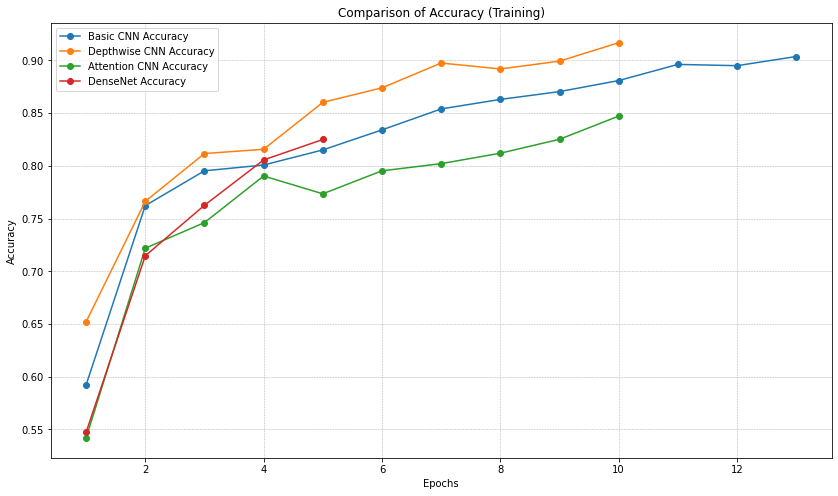

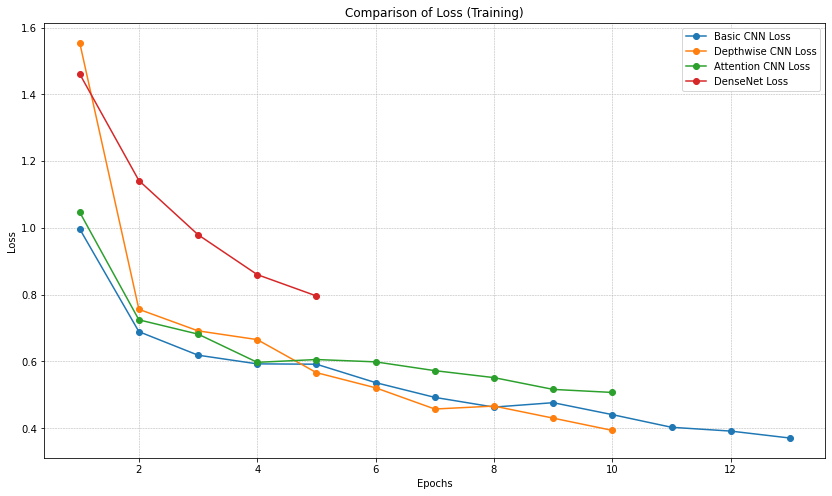

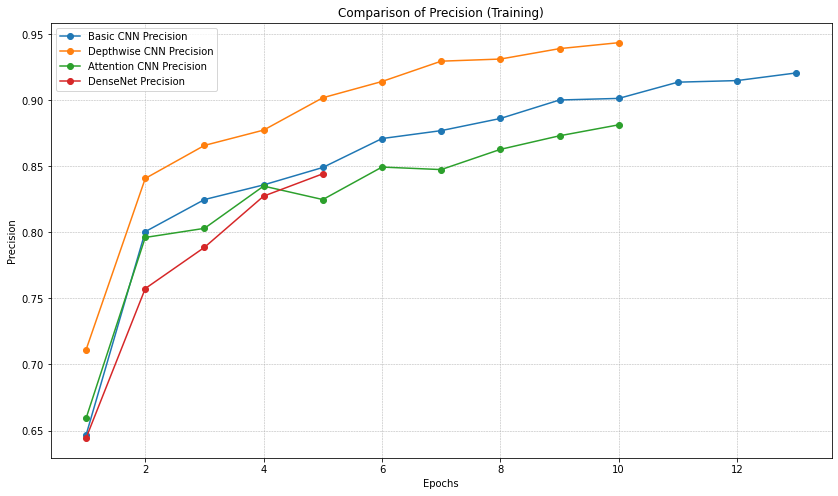

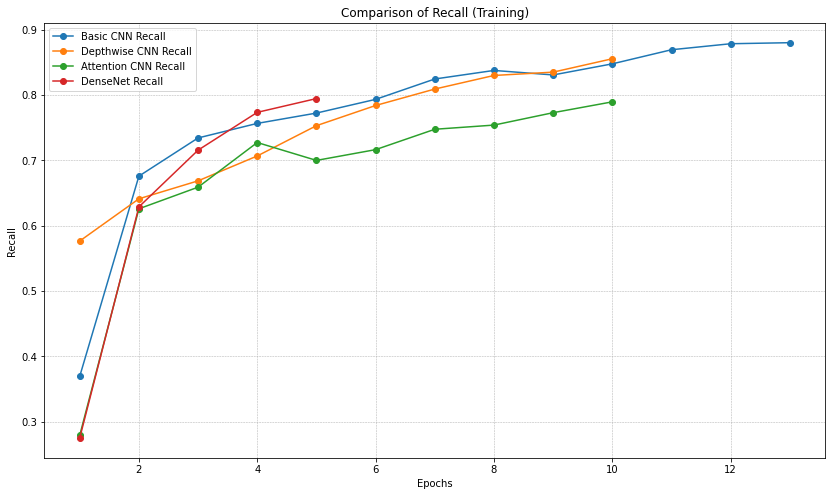

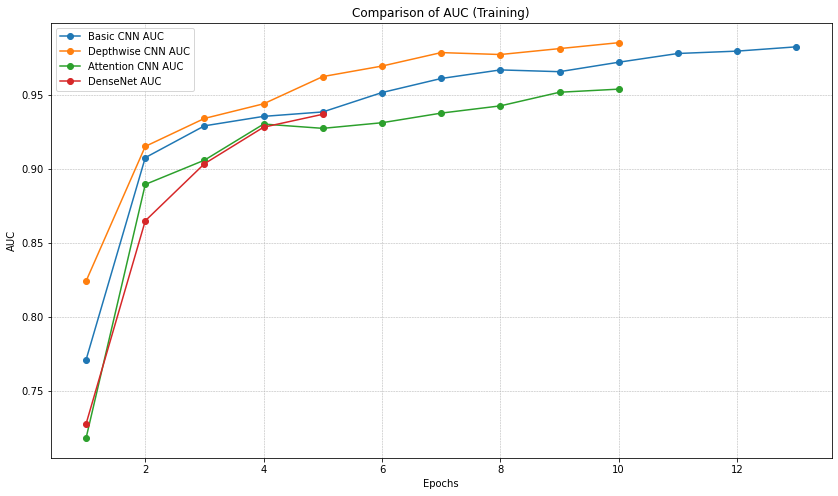

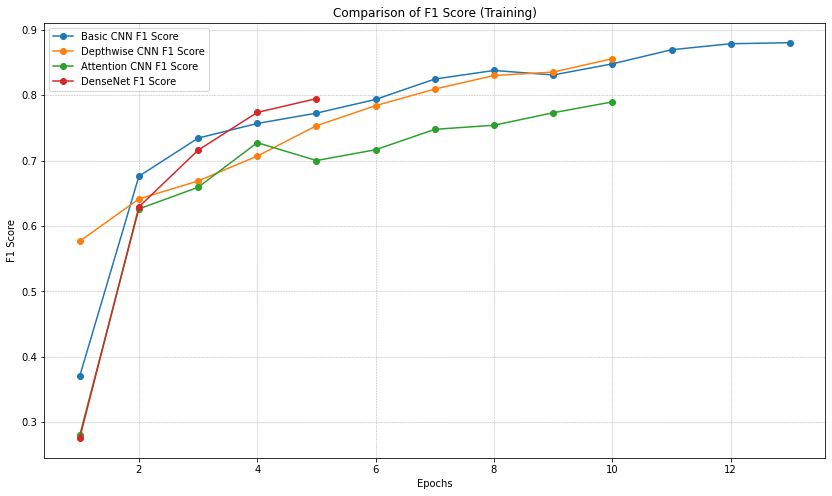

In [54]:
import matplotlib.pyplot as plt

# Combine training and validation metrics into a single dictionary for each model
def combine_metrics(train_metrics, val_metrics):
    combined_metrics = {}
    for key in train_metrics.keys():
        combined_metrics[key] = train_metrics[key]
        combined_metrics[f'val_{key}'] = val_metrics[f'val_{key}']
    return combined_metrics

# Combine the metrics for each model
basic_cnn_metrics = combine_metrics(basic_cnn_train_metrics, basic_cnn_val_metrics)
depthwise_cnn_metrics = combine_metrics(depthwise_cnn_train_metrics, depthwise_cnn_val_metrics)
attention_cnn_metrics = combine_metrics(attention_cnn_train_metrics, attention_cnn_val_metrics)
densenet_metrics = combine_metrics(densenet_train_metrics, densenet_val_metrics)

# Collect all models' metrics
models = {
    'Basic CNN': basic_cnn_metrics,
    'Depthwise CNN': depthwise_cnn_metrics,
    'Attention CNN': attention_cnn_metrics,
    'DenseNet': densenet_metrics
}

# Function to plot comparison for a single metric on training data
def plot_training_comparison(metric, metric_name, models):
    plt.figure(figsize=(14, 8))
    
    for model_name, data in models.items():
        epochs = range(1, len(data[metric]) + 1)
        plt.plot(epochs, data[metric], marker='o', linestyle='-', label=f'{model_name} {metric_name}')
    
    plt.title(f'Comparison of {metric_name} (Training)')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Plot comparisons for each metric on training data
plot_training_comparison('accuracy', 'Accuracy', models)
plot_training_comparison('loss', 'Loss', models)
plot_training_comparison('precision', 'Precision', models)
plot_training_comparison('recall', 'Recall', models)
plot_training_comparison('auc', 'AUC', models)
plot_training_comparison('f1_score', 'F1 Score', models)


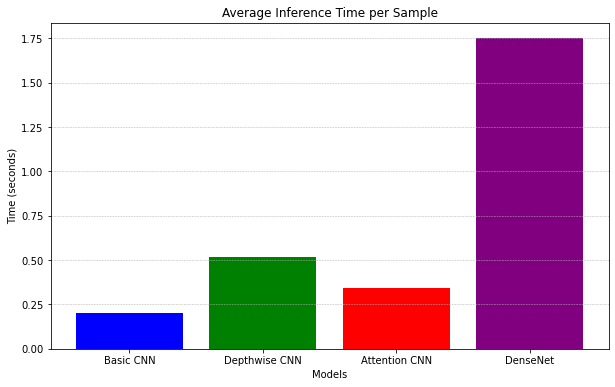

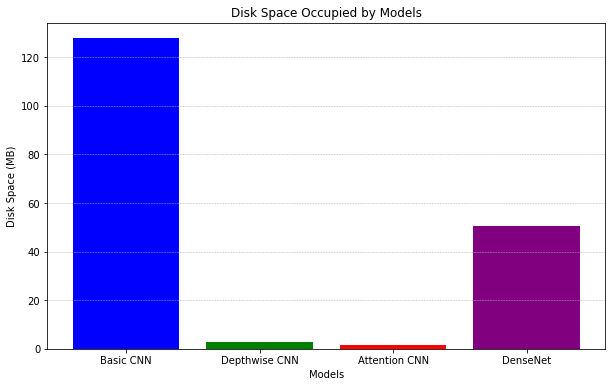

In [55]:
import matplotlib.pyplot as plt

# Inference metrics for each model
inference_metrics = {
    'Basic CNN': {'average_inference_time_per_sample': 0.2002, 'memory_usage_mb': 127.86},
    'Depthwise CNN': {'average_inference_time_per_sample': 0.5185, 'memory_usage_mb': 2.63},
    'Attention CNN': {'average_inference_time_per_sample': 0.3443, 'memory_usage_mb': 1.56},
    'DenseNet': {'average_inference_time_per_sample': 1.7510, 'memory_usage_mb': 50.35}
}

# Extracting the data for plotting
models = list(inference_metrics.keys())
inference_times = [inference_metrics[model]['average_inference_time_per_sample'] for model in models]
memory_usages = [inference_metrics[model]['memory_usage_mb'] for model in models]

# Plotting the Average Inference Time per Sample
plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green', 'red', 'purple'])
plt.title('Average Inference Time per Sample')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

# Plotting the Disk Space Occupied by Models
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usages, color=['blue', 'green', 'red', 'purple'])
plt.title('Disk Space Occupied by Models')
plt.xlabel('Models')
plt.ylabel('Disk Space (MB)')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Get true labels and predicted labels
def get_labels_and_predictions(model, test_ds):
    y_true = []
    y_pred = []
    
    # Loop over test set batches
    for images, labels in test_ds:
        # Get the true class indices from one-hot encoded labels
        y_true_batch = np.argmax(labels.numpy(), axis=1)
        # Predict using the model
        predictions = model.predict(images)
        # Get the predicted class indices
        y_pred_batch = np.argmax(predictions, axis=1)
        
        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)
    
    return np.array(y_true), np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

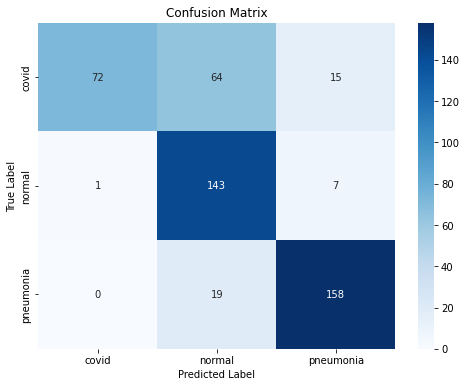

In [57]:
model = basic_cnn 

# Get the true and predicted labels
y_true, y_pred = get_labels_and_predictions(model, test_ds)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━

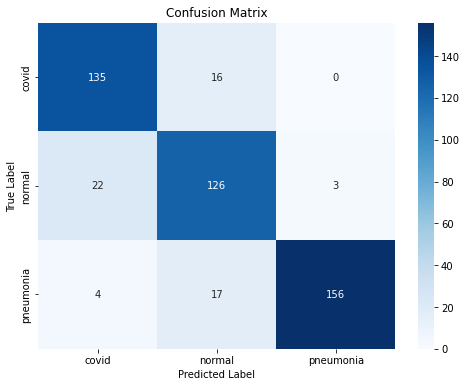

In [58]:
model = advanced_depthwise_cnn 

# Get the true and predicted labels
y_true, y_pred = get_labels_and_predictions(model, test_ds)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

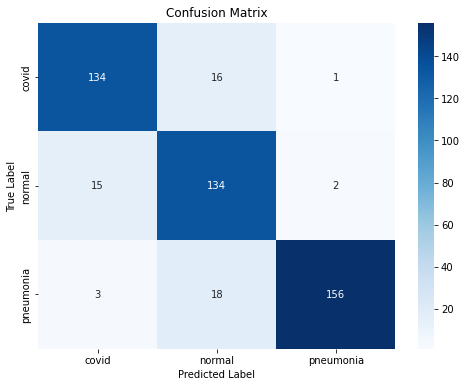

In [59]:
model = advanced_cnn_with_attention

# Get the true and predicted labels
y_true, y_pred = get_labels_and_predictions(model, test_ds)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

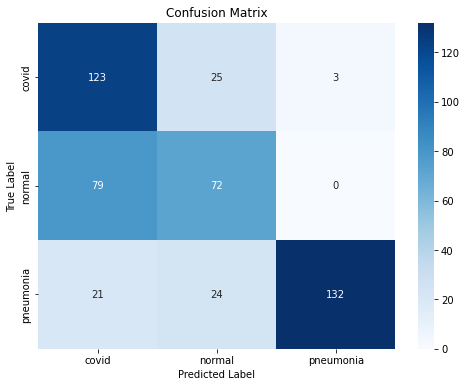

In [60]:
model = densenet

# Get the true and predicted labels
y_true, y_pred = get_labels_and_predictions(model, test_ds)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)
